# BPDM 2019 In the Lab Tutorial - Fairness in Data Mining: COMPAS Dataset

## Requirements:

__Tools:__ Analysis will be done in python, using a number of useful open source python packages:
- __Numpy__ Python's scientific computing package. http://www.numpy.org/
- __Pandas__ A very useful data analysis and manipulation package http://pandas.pydata.org/
- __Scikit-learn__ A comprehensive machine learning library http://scikit-learn.org/stable/
- __Matplotlib__ Package for creating charts and other visualizations https://matplotlib.org/

All these packages come bundled as part of the Anaconda python distribution. Install Anaconda for the simplest way to get all dependancies for the tutorial:
__Anaconda__ https://www.anaconda.com/download/

## Running the notebook:

This notebook contains different *cells* containing executable code. You can run the code in each cell below by clicking on the cell and using the run button in the toolbar above, or using ctrl+enter or shift+enter 

The output from the code (or an error!) will appear below the cell when you run it. Here is [more info](https://jupyter-notebook.readthedocs.io/en/stable/) on using Jupyter Notebooks.

Let's get started by importing the libraries we will use.


In [36]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_curve
from utilities import *
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Overview

This notebook was originally created by Flavio Calmon for the 2017 BPDM workshop @SIGKDD and revised by Caitlin Kuhlman for the 2019 BPDM Workshop @Howard University. 

This tutorial aims to introduce some techniques for identifying and mitigating unfair bias in a machine learning pipeline. We will analyze the COMPAS criminal recidivism dataset published by ProPublica in the article 
[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). Their analysis and the release of this dataset prompted much research in the machine learning community (See the [references](#References) at the end of the notebook). 

The dataset consists of COMPAS scores assigned to defendants over two years 2013-2014 in Broward County, Florida. These scores are determined by a proprietary algorithm designed to evaluate a persons recidivism risk - the likelihood that they will reoffend. Risk scoring algorithms are widely used by judges to inform their scentencing and bail decisions in the criminal justice system in the United States. The original ProPublica analysis identified a number of fairness concerns around the use of COMPAS scores, including that ''black defendants were nearly twice as likely to be misclassified as higher risk compared to their white counterparts.'' Please see the full article for further details.

The tutorial proceeds with the following tasks:

**Step 1. Data Prep**

- We first clean and preprocess the data according to the steps taken in the [ProPublica analysis](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

**Step 2. Data Exploration**

- We analyze the attributes in the training dataset to understand them better and assess whether there is any unfair bias present in the data.

**Step 3. Fairness Metrics**

- We introduce some recently proposed metrics for evaluating group fairness to apply to our problem.

### Coming soon:

**Step 4. Prediction of COMPAS Scores**
- To simulate the proporietary models used in risk scoring, we train a binary classifier to predict COMPAS scores.
- Error-based fairness criteria are applied to evaluate the fairness of the resulting model.


**Step 5. Discussion of Mitigation techniques**
- What steps can we take to mitigate any observed unfairness in this data analysis pipeline?

Suggestions for further experimentation are given throughout in <font color=red> Red!</font>



## Step 1: Data prep

First we import the COMPAS dataset and store it in a Pandas [dataframe](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html) object.

In [37]:
# df = pd.read_csv("https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv", 
#                  header=0).set_index('id')

# TO SAVE A LOCAL COPY
# df.to_pickle("compas.pkl")

#TO READ FROM FILE
df = pd.read_pickle("compas.pkl")

First, let's take a look at this dataset. We print the features, and then the first entries.

In [38]:
print(list(df))
df.head()

['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date', 'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event', 'two_year_recid']


,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Data Cleaning

For this analysis, we will restrict ourselves to only a few features, and clean the dataset according to the methods using in the original ProPublica analysis. 

Details of the cleaning method can be found in the utilities file.

In [39]:
# Select features that will be analyzed
features_to_keep = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
df = df[features_to_keep]
df = clean_compas(df)
df.head()
print("\ndataset shape (rows, columns)", df.shape)

Number of rows removed: 1042
Features: ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay']

dataset shape (rows, columns) (6172, 14)


## Step 2: Data Exploration

Next we provide a few ways to look at the relationships between the attributes in the dataset. Here is an explanation of these values:

* `age`: defendant's age
* `c_charge_degree`: degree charged (Misdemeanor of Felony)
* `race`: defendant's race
* `age_cat`: defendant's age quantized in "less than 25", "25-45", or "over 45"
* `score_text`: COMPAS score: 'low'(1 to 5), 'medium' (5 to 7), and 'high' (8 to 10).
* `sex`: defendant's gender
* `priors_count`: number of prior charges
* `days_b_screening_arrest`: number of days between charge date and arrest where defendant was screened for compas score
* `decile_score`: COMPAS score from 1 to 10 (low risk to high risk)
* `is_recid`: if the defendant recidivized
* `two_year_recid`: if the defendant within two years
* `c_jail_in`: date defendant was imprisoned
* `c_jail_out`: date defendant was released from jail
* `length_of_stay`: length of jail stay

In particular, as in the ProPublica analysis, we are interested in the implications for the treatment of different groups as defined by some **sensitive data attributes**. In particular we will consider race as the protected attribute in our analysis. Next we look at the number of entries for each race.


<font color=red> Another interesting fairness analysis might be to consider group outcomes by gender or age. In fact, a [recent appeal to the supreme court](https://en.wikipedia.org/wiki/Loomis_v._Wisconsin) challenged the role of gender in determining COMPAS scores.</font> 

In [40]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

We restrict our analysis to African-American and Caucasian, since we have significantly more samples for these two groups. We remove entries not marked as African-American or Caucasian, and look at the distribution of COMPAS scores.

In [41]:
df = df.loc[df['race'].isin(['African-American','Caucasian'])]

### COMPAS score distribution

Let's look at the COMPAS score distribution between African-Americans and Caucasians (matches the one in the ProPublica article).

In [42]:
table = df.groupby(['race','decile_score']).size().reset_index().pivot(index='decile_score',columns='race',values=0)

# percentage of defendants in each score category
100*table/table.sum()

race,African-American,Caucasian
decile_score,,
1,11.496063,28.768426
2,10.897638,15.263909
3,9.385827,11.317166
4,10.614173,11.554922
5,10.173228,9.510223
6,10.015748,7.608179
7,10.803150,5.373276
8,9.480315,4.564907
9,9.984252,3.661436


Text(0,0.5,'Fraction of population')

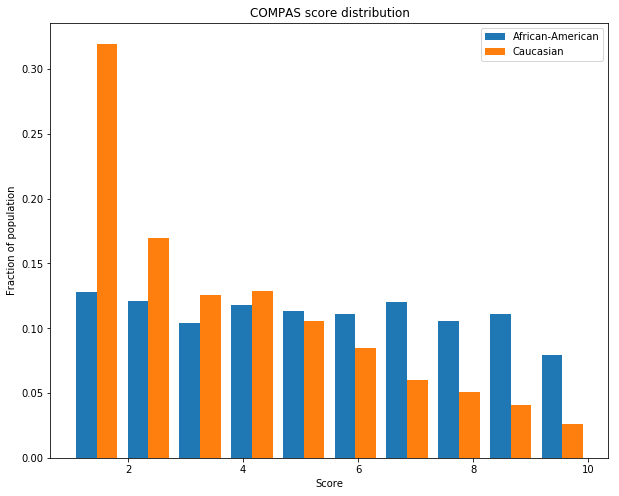

In [43]:
# now in visual form
x = df.loc[df['race']=='African-American','decile_score'].values
y = df.loc[df['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[10,8])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

As you can observe, there is a large discrepancy. Does this change when we condition on other random variables? Let's look at the distribution of scores for individuals with more than 2 priors.

Text(0,0.5,'Fraction of population')

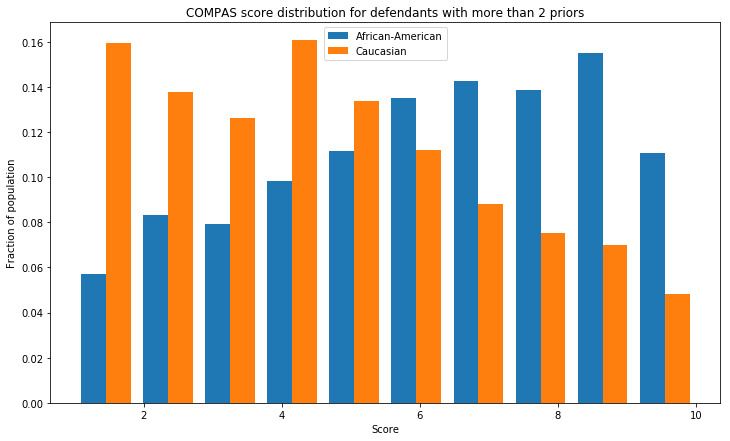

In [44]:
df_2priors = df.loc[df['priors_count']>=2]
x = df_2priors.loc[df_2priors['race']=='African-American','decile_score'].values
y = df_2priors.loc[df_2priors['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution for defendants with more than 2 priors')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

Still a big difference.

### Question: ###
How does the COMPAS score distribution change under different conditionings (e.g. degree charged, length of prison stay, etc.)? Does a [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox)-like phenomenom happen?

Text(0,0.5,'Fraction of population')

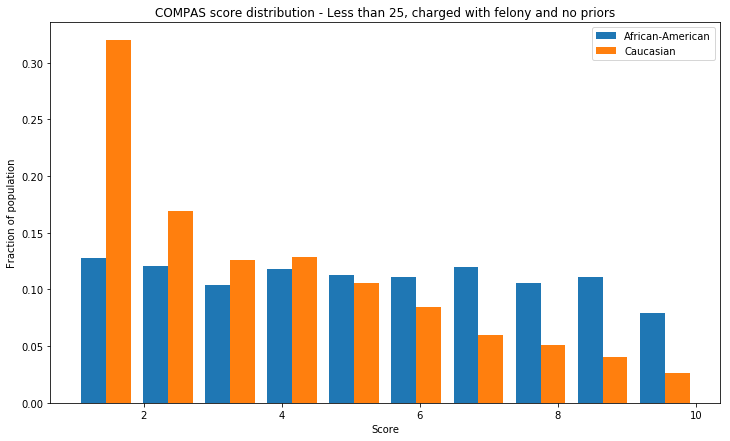

In [45]:
# hard to find... For example at young felons with no priors
df_ans = df.loc[(df['priors_count']==0)&(df['c_charge_degree']=='F')&df['age']<=25]
x = df_ans.loc[df_ans['race']=='African-American','decile_score'].values
y = df_ans.loc[df_ans['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution - Less than 25, charged with felony and no priors')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

We quantize our dataset next to make the analysis a little bit easier.

In [46]:
dfQ = df.copy()

# Quantize priors count between 0, 1-3, and >3
def quantizePrior(x):
    if x <=0:
        return '0'
    elif 1<=x<=3:
        return '1 to 3'
    else:
        return 'More than 3'

    
# Quantize length of stay
def quantizeLOS(x):
    if x<= 7:
        return '<week'
    if 8<x<=93:
        return '<3months'
    else:
        return '>3 months'
    
# Quantize length of stay
def adjustAge(x):
    if x == '25 - 45':
        return '25 to 45'
    else:
        return x

# Quantize score_text to MediumHigh
def quantizeScore(x):
    if (x == 'High')| (x == 'Medium'):
        return 1
    else:
        return 0

    
dfQ['priors_count'] = dfQ['priors_count'].apply(quantizePrior)
dfQ['length_of_stay'] = dfQ['length_of_stay'].apply(quantizeLOS)
dfQ['score_text'] = dfQ['score_text'].apply(quantizeScore)
dfQ['age_cat'] = dfQ['age_cat'].apply(adjustAge)

Now we can look at the percentage difference of the average COMPAS scores between Caucasians and African-Americans for different groups. (**Important**: error bars omitted, so large differences may be due to limited samples)

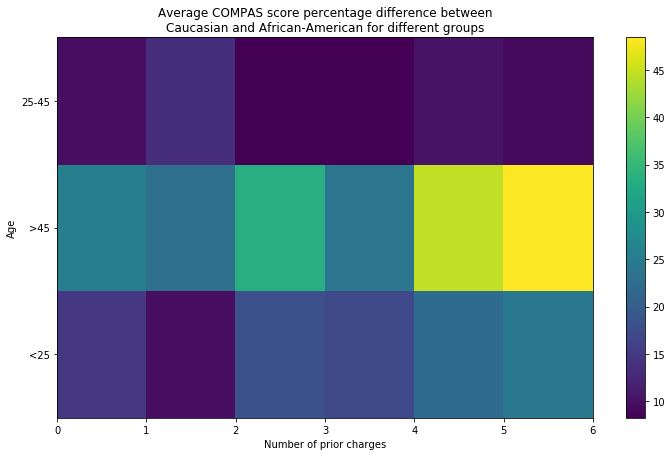

In [61]:
# African-american
dfPlot_AA = dfQ.loc[dfQ['race']=='African-American'].copy()
dfPlot_AA = dfPlot_AA.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_AA = dfPlot_AA.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

# Caucasian
dfPlot_C = dfQ.loc[dfQ['race']=='Caucasian'].copy()
dfPlot_C = dfPlot_C.groupby(['age_cat','c_charge_degree','priors_count'])['decile_score'].mean().reset_index()
dfinal_C = dfPlot_C.pivot_table(index =['age_cat'],columns = ['c_charge_degree','priors_count'],values="decile_score")

plt.figure(figsize=[12,7])
# sns.heatmap(100*(dfinal_AA.div(dfinal_C)-1),cmap="coolwarm",annot=True)
f = 100*(dfinal_AA.div(dfinal_C)-1)
plt.pcolor(f)
plt.colorbar()
plt.yticks([0.5,1.5,2.5],['<25', '>45', '25-45'])
# plt.yticklabels(
plt.ylabel("Age")
plt.xlabel("Number of prior charges")
plt.title('Average COMPAS score percentage difference between\nCaucasian and African-American for different groups')
plt.show()

What's happening with the "greater than 45" group? Let's plot the score distribution for that group.

Text(0,0.5,'Fraction of population')

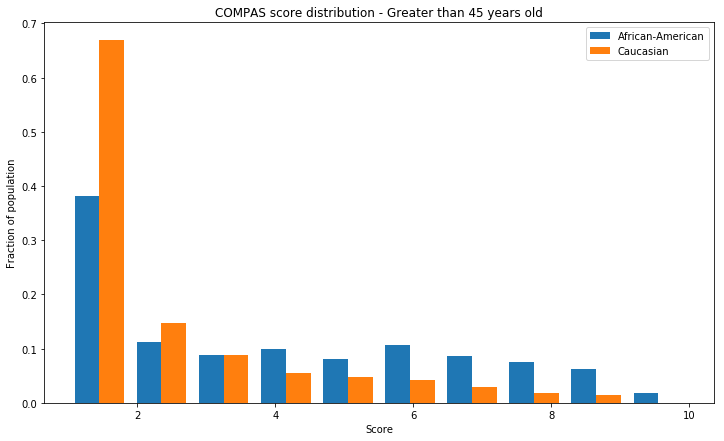

In [62]:
# hard to find... For example at young felons with no priors
df_g45 = df.loc[(df['age']>=45)]
x = df_g45.loc[df_g45['race']=='African-American','decile_score'].values
y = df_g45.loc[df_g45['race']=='Caucasian','decile_score'].values
plt.figure(figsize=[12,7])
plt.hist([x,y],normed=True)
plt.legend(['African-American','Caucasian'])
plt.title('COMPAS score distribution - Greater than 45 years old')
plt.xlabel('Score')
plt.ylabel('Fraction of population')

## What happens when we take actual 2-year recidivism values into account? Are the predictions fair?

First, let's look at the correlation between the quantized score, the decile score and the actual recidivism.

In [34]:
# Correlation between COMPAS score and 2-year recidivism

# measure with high-low score
print(dfQ[['two_year_recid','score_text']].corr())

# measure with decile_score
print(dfQ[['two_year_recid','decile_score']].corr())

                two_year_recid  score_text
two_year_recid        1.000000    0.314698
score_text            0.314698    1.000000
                two_year_recid  decile_score
two_year_recid        1.000000      0.368193
decile_score          0.368193      1.000000


## Step 3: Fairness Metrics

The question of how to determine if an algorithm is *fair* has seen much debate recently (see this tutorial from the Conference on Fairness, Acountability, and Transparency titled [21 Fairness Definitions and Their Politics](https://fatconference.org/2018/livestream_vh220.html).

And in fact some of the definitions are contradictory, and have been shown to be mutually exclusive [2,3] https://www.propublica.org/article/bias-in-criminal-risk-scores-is-mathematically-inevitable-researchers-say

Here we will cover 3 notions of fairness and present ways to measure them:

1. **Disparate Impact** [4](#References) 
[The 80% rule](https://en.wikipedia.org/wiki/Disparate_impact#The_80.25_rule)

2. **Calibration** [6](#References)

4. **Equalized Odds** [5](#References) 


The correlation is not that high. Let's measure the disparate impact of the quantized COMPAS score ($\leq4$ is low, everything else is high) according to the EEOC rule that the values with "high" for each protected group should be within 80% of each other. Of course, the interpertation here is not the same, but it's a good starting point.


In [63]:
# The correlation is not that high. Let's measure the disparate impact according to the EEOC rule
means = dfQ.groupby(['score_text','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print('Percentage difference: %f%%' %percentage_diff)

race        African-American  Caucasian
score_text                             
0                   0.423937   0.669044
1                   0.576063   0.330956
Percentage difference: 74.060413%


The percentage of African-Americans who receive a higher score is 74% higher than Caucasians, so the COMPAS algorithm seems to have a disparate impact based on this rule. How does this change when we apply the same rule with with the true two year recidivism instead of the quantized COMPAS score?

In [64]:
means = dfQ.groupby(['two_year_recid','race']).size().unstack()
means = means/means.sum()
print(means)
# compute disparte impact
AA_with_high_score = means.loc[1,'African-American']
C_with_high_score = means.loc[1,'Caucasian']
percentage_diff = 100*(AA_with_high_score/C_with_high_score -1)
print(percentage_diff)

race            African-American  Caucasian
two_year_recid                             
0                        0.47685    0.60913
1                        0.52315    0.39087
33.8422897868


There is a difference in recidivism, but not as high as assigned by the COMPAS scores.

Now let's measure the difference in scores when we consider both the COMPAS output at true recidivism.

We will consider a few different metrics. Further explaination can be found in North Point's response to the ProPublica article, and also in Alexandra Chouldechova’s paper (listed above). The link for it is https://assets.documentcloud.org/documents/2998391/ProPublica-Commentary-Final-070616.pdf . The discussion on error rates and calibration also appear in both. 

We first look at a metric called *callibration*. For $Y$ indicating two year recidivism, $S_Q$ indicating score (0=low, 1=high medium), and $R$ indicating race, we measure
$$\mathsf{cal} \triangleq \frac{\mathbb{P}\left(Y=1\mid S_Q=s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S_Q=s,R=\mbox{Caucasian} \right)},$$ for different scores $s$. Considering our quantized scores, we look at the calibration for $s=1$. 

In [18]:
# compute averages
dfAverage = dfQ.groupby(['race','score_text'])['two_year_recid'].mean().unstack()
print(dfAverage)

num = dfAverage.loc['African-American',1]
denom = dfAverage.loc['Caucasian',1]
cal = num/denom
calpercent = 100*(cal-1)
print('Calibration: %f' % cal)
print('Calibration in percentage: %f%%' % calpercent)

score_text               0         1
race                                
African-American  0.351412  0.649535
Caucasian         0.289979  0.594828
Calibration: 1.091972
Calibration in percentage: 9.197233%


The difference looks much smaller than before. The problem of the above calibration measure is that it depends on the threshold on which we quantized the scores $S_Q$. In order to mitigate this, let's look at a measure called *predictive parity.* In this example, we define predictive parity as
$$\mathsf{PP}(s) \triangleq \frac{\mathbb{P}\left(Y=1\mid S\geq s,R=\mbox{African-American} \right)}{\mathbb{P}\left(Y=1 \mid S\geq s,R=\mbox{Caucasian} \right)},$$
where $S$ is the original score.

We plot $\mathsf{PP}(s) $ for $s$ from 1 to 10. 

Text(0.5,1,'Predictive parity for different thresholds\n(warning: no error bars)')

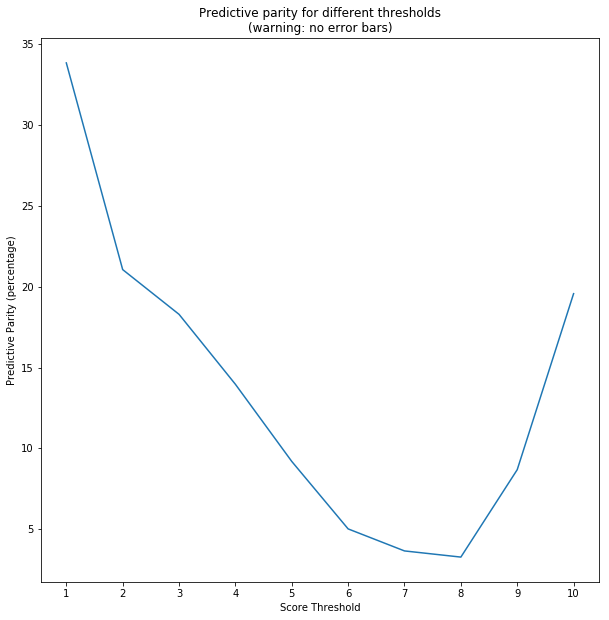

In [19]:
# aux function for thresh score
def threshScore(x,s):
    if x>=s:
        return 1
    else:
        return 0

ppv_values = []
dfP = dfQ[['race','two_year_recid']].copy()
for s in range(1,11):
    dfP['threshScore'] = dfQ['decile_score'].apply(lambda x: threshScore(x,s))
    dfAverage = dfP.groupby(['race','threshScore'])['two_year_recid'].mean().unstack()
    num = dfAverage.loc['African-American',1]
    denom = dfAverage.loc['Caucasian',1]
    ppv_values.append(100*(num/denom-1))


plt.figure(figsize=[10,10])
plt.plot(range(1,11),ppv_values)
plt.xticks(range(1,11))
plt.xlabel('Score Threshold')
plt.ylabel('Predictive Parity (percentage)')
plt.title('Predictive parity for different thresholds\n(warning: no error bars)')

Note how predictive parity depends significantly on the threshold.

We analyze next the difference in *error rates* between groups. First, we look at is the ROC for each group. We normalize the score between 0 and 1. The ROC thresholds produced by `scikitlearn` are the same.

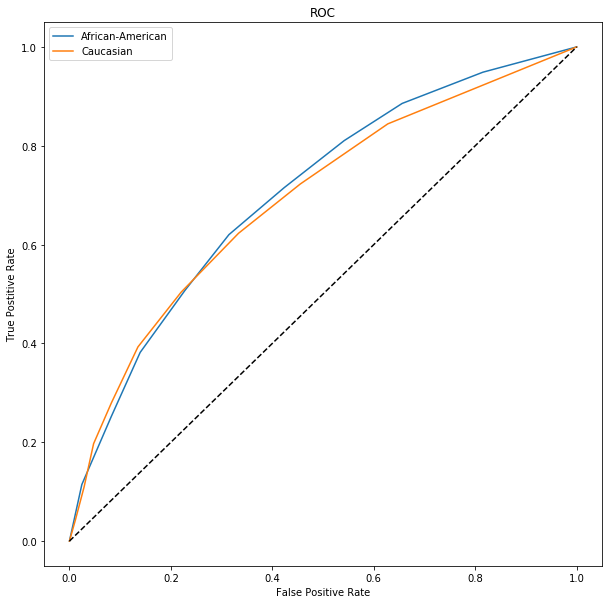

In [20]:
# normalize decile score
max_score = dfQ['decile_score'].max()
min_score = dfQ['decile_score'].min()
dfQ['norm_score'] = (dfQ['decile_score']-min_score)/(max_score-min_score)


plt.figure(figsize=[10,10])
#plot ROC curve for African-Americans
y = dfQ.loc[dfQ['race']=='African-American',['two_year_recid','norm_score']].values
fpr1,tpr1,thresh1 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr1,tpr1)

#plot ROC curve for Caucasian
y = dfQ.loc[dfQ['race']=='Caucasian',['two_year_recid','norm_score']].values
fpr2,tpr2,thresh2 = roc_curve(y_true = y[:,0],y_score=y[:,1])
plt.plot(fpr2,tpr2)
l = np.linspace(0,1,10)
plt.plot(l,l,'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Postitive Rate')
plt.title('ROC')
plt.legend(['African-American','Caucasian'])


For each group, the point in the ROC curve corresponds to a $$(\mbox{false postive rate, true positive rate})$$ pair for a given threshold. In order to caputre the difference in error rates, we map the points to $$\left(\frac{\mbox{false postive rate Afr.-American}}{\mbox{false postive rate Cauc.}},s \right)$$
and similarly for *false negative* rates for different thersholds s.

Text(0.5,1,'Ratio between African-American and Caucasian error rates\n for different score thresholds')

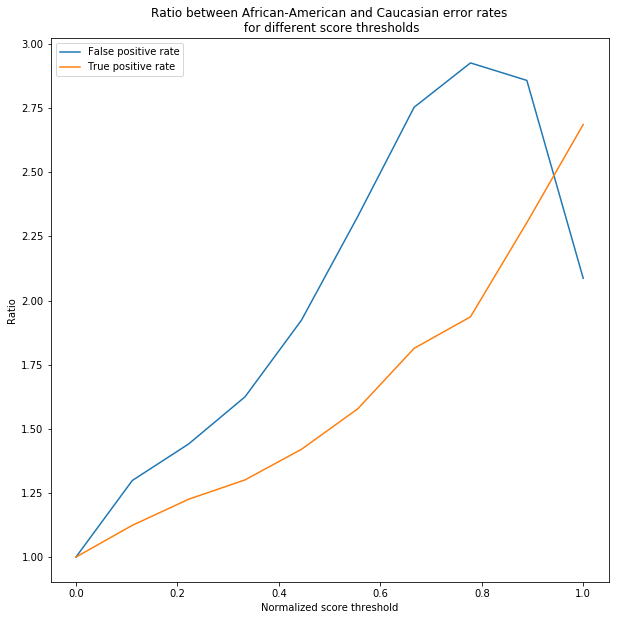

In [21]:
fpr_ratio = fpr1[1:]/fpr2[1:]
tpr_ratio = (tpr1[1:])/(tpr2[1:])
plt.figure(figsize=[10,10])
plt.plot(thresh1[1:],fpr_ratio)
plt.plot(thresh1[1:],tpr_ratio)
plt.xlabel('Normalized score threshold')
plt.ylabel('Ratio')

plt.legend(['False positive rate','True positive rate'])
plt.title('Ratio between African-American and Caucasian error rates\n for different score thresholds')

The difference is once again stark. This graph is particlarly concerning due to the significantly higher false positive rates for African Americans across all thresholds.

## References

[1] ProPublica, *“Machine Bias,”* https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing, May 2016.

[2] A. Chouldechova. *"Fair prediction with disparate impact: A study of bias in recidivism prediction instruments."* arXiv preprint arXiv:1703.00056 (2017).

[3] Kleinberg, Jon, Sendhil Mullainathan, and Manish Raghavan. "Inherent trade-offs in the fair determination of risk scores." arXiv preprint arXiv:1609.05807 (2016).

[4] Feldman, Michael, Sorelle A. Friedler, John Moeller, Carlos Scheidegger, and Suresh Venkatasubramanian. *"Certifying and removing disparate impact."* In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 259-268. ACM, 2015.

[5] Hardt, Moritz, Eric Price, and Nati Srebro. *"Equality of opportunity in supervised learning."* Advances in neural information processing systems. 2016.

[6] Dieterich, William, Christina Mendoza, and Tim Brennan. "COMPAS risk scales: Demonstrating accuracy equity and predictive parity." Northpoint Inc (2016).

[7] F. P. Calmon, D. Wei, K. Natesan Ramamurthy, and K. R. Varshney, *“Optimized Data Pre- Processing for Discrimination Prevention,”* arXiv preprint arXiv:1704.03354 (2017)